In [1]:
import os
import time
import argparse
import scipy as sp
import scipy.stats as stats
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import logging
import yaml
from bids.layout import BIDSLayout
import nibabel as nib
from prfpy.rf import vonMises1D as vm
from prfpy.rf import gauss1D_cart as g1d
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf

In [2]:
def save_nii(data, refdata, outputdir, filename):
    filepath = Path(outputdir, filename)
    nib.save(
        nib.Nifti1Image(
            data,
            affine=refdata.affine,
            header=refdata.header,
        ),
        filepath,
    )


def calc_stim_radius(stim_size, stim_center_dist):
    """Calculate the size of the circle in angle units from visual angle units"""
    return np.degrees(np.arctan((stim_size / 2) / stim_center_dist))


def con_dm(ev_df, design_opt):
    TR_nr_from_DM = ev_df["event_type"].value_counts().pulse
    if TR_nr_from_DM + design_opt["blank_TR_nr"] != design_opt["TR_nr"]:
        logging.warning(
            f'Number of TRs from DM ({TR_nr_from_DM}) is not equal to the number of TRs from design_opt ({design_opt["TR_nr"]})'
        )
    start_timepoint = ev_df[
        (ev_df["trial_nr"] == 1) & (ev_df["event_type"] == "pulse")
    ]["onset"].values[0]
    # Correct the start time
    ev_df["onset"] = ev_df["onset"] - start_timepoint
    onset_df = ev_df[["onset", "angle_Ping", "ori_Ping", "direction"]][
        (ev_df["trial_type"] == "PingTrial") & (ev_df["event_type"] == "stimulus")
    ].reset_index(drop=True)

    onset_df["onset"] = onset_df["onset"] * 10
    onset_df["onset"] = onset_df["onset"].astype("int")
    onset_df["angle_Ping"] = onset_df["angle_Ping"].astype("int")
    onset_df["ori_Ping"] = onset_df["ori_Ping"].astype("int")

    dm = np.zeros(
        (
            len(np.arange(0, design_opt["total_time"], design_opt["pseudo_TR"])),
            len(design_opt["angles"]),
        ),
        dtype=int,
    )
    for _, row in onset_df.iterrows():
        TR_ind = int(
            (row["onset"] - design_opt["fixation_dur"] * 10)
            / (design_opt["pseudo_TR"] * 10)
        )
        column_ind = np.where(design_opt["angles"] == row["angle_Ping"])
        dm[TR_ind, column_ind] = 1

    return dm, onset_df


def con_dms(bids_layout, design_opt):
    """Design matrix"""
    sub = design_opt["sub"]
    ses = design_opt["ses"]
    runs = design_opt["runs"]
    ev_dfs = []
    dms = []
    stim_dms = []
    for run in runs:
        logging.info(f"Loading event file for run {run}")
        event_file = bids_layout.get(
            subject=sub,
            session=ses,
            task="ping",
            run=run,
            suffix="events",
            extension="tsv",
        )[0]
        logging.info(f"Event file path: {event_file.path}")
        ev_dfs.append(pd.read_csv(event_file.path, sep="\t"))

    for ev_df in ev_dfs:
        dm, onset_df = con_dm(ev_df, design_opt)
        dms.append(dm)
        stim_dms.append(np.array(onset_df["angle_Ping"]))
    return dms, stim_dms


def con_imgs(fmriprep_layout, design_opt):
    # nifti file
    imgs = []
    sub = design_opt["sub"]
    ses = design_opt["ses"]
    runs = design_opt["runs"]

    for run in runs:
        logging.info(f"Loading func image for run {run}")
        nifti_file = fmriprep_layout.get(
            subject=sub,
            session=ses,
            task="ping",
            run=run,
            space="T1w",
            suffix="bold",
            extension="nii.gz",
        )[0]
        logging.info(f"BOLD file path: {nifti_file.path}")
        datvol = nib.load(nifti_file)
        imgs.append(datvol.get_fdata())
        logging.info(f"The image size of run {run} is {imgs[-1].shape}")
    return imgs


def con_vonmises_grid(
    angle_nr,
    oversamplingratio=9,
    kappas_nr=20,
    kappa_range=[0.1, 50],
):
    """
    :param angle_nr: number of angles
    :param oversamplingratio: oversampling ratio for mu
    :param kappa_nr: number of kappa values
    :param kappa_range: range of kappa values
    :return: 2D array of von mises values"""
    kappa_log10_range = [np.log10(kappa_range[0]), np.log10(kappa_range[1])]
    mus = np.linspace(0, 2 * np.pi, oversamplingratio * angle_nr, endpoint=False)
    kappas = np.logspace(
        kappa_log10_range[0], [kappa_log10_range[1]], kappas_nr, endpoint=True
    )
    mugrid, kappagrid = np.meshgrid(mus, kappas)
    mugrid, kappagrid = mugrid.ravel(), kappagrid.ravel()
    return (
        np.array([vm(mus, mu, kappa) for mu, kappa in zip(mugrid, kappagrid)]),
        mugrid,
        kappagrid,
    )


def angle_to_stim_screen(stim_angle, angle_nr, stim_radius, oversamplingratio=9):
    radians = np.linspace(
        0, np.radians(360), angle_nr * oversamplingratio, endpoint=False
    )
    low_bound = np.radians((stim_angle - stim_radius) % 360)
    high_bound = np.radians((stim_angle + stim_radius) % 360)
    stim_radian = np.radians(stim_angle % 360)
    idx_low_bound = (np.abs(radians - low_bound)).argmin()
    idx_high_bound = (np.abs(radians - high_bound)).argmin()
    stim_screen = np.zeros_like(radians)
    if (high_bound < low_bound) and (stim_radius >= 360/(angle_nr*oversamplingratio*2)) :
        stim_screen[idx_low_bound:] = 1
        stim_screen[: idx_high_bound + 1] = 1
    elif (high_bound < low_bound) and (stim_radius < 360/(angle_nr*oversamplingratio*2)):
        stim_screen[: idx_high_bound + 1] = 1
    else:
        stim_screen[idx_low_bound : idx_high_bound + 1] = 1
    return stim_screen


def con_vonmises_dm(
    dm: np.ndarray,
    angle_nr: int = 8,
    stim_radius: int = 0.7,
    oversamplingratio: int = 9,
):
    angles = np.linspace(0, 360, angle_nr, endpoint=False)

    new_dm = np.zeros((dm.shape[0], angle_nr * oversamplingratio))
    for TR_ind in range(dm.shape[0]):
        if any(dm[TR_ind, :]):
            angle = angles[np.where(dm[TR_ind, :])[0][0]]
            new_dm[TR_ind, :] = angle_to_stim_screen(
                angle, angle_nr, stim_radius, oversamplingratio=oversamplingratio
            )
    return new_dm


def model_timecourse(model, dm):
    return np.dot(model.ravel(), dm.T.reshape((-1, dm.shape[0])))


def rsq_for_model(data, model_tcs, return_yhat=False):
    """
    Parameters
    ----------
    data : numpy.ndarray
        1D or 2D, containing single time-course or multiple
    model_tcs : numpy.ndarray
        1D, containing single model time-course
    Returns
    -------
    rsq : float or numpy.ndarray
        within-set rsq for this model's GLM fit, for all voxels in the data
    yhat : numpy.ndarray
        1D or 2D, model time-course for all voxels in the data

    """
    dm = np.vstack([np.ones(data.shape[-1]), model_tcs]).T
    betas = np.linalg.lstsq(dm, data.T, rcond=None)[0]
    yhat = np.dot(dm, betas).T
    rsq = 1 - (data - yhat).var(-1) / data.var(-1)
    if return_yhat:
        return rsq, yhat
    else:
        return rsq


def grid_search_for_voxel(sv_tcs, grid_model_timecourses_conv, mugrid, kappagrid):
    rsqs = np.array(
        [rsq_for_model(sv_tcs, mtcs) for mtcs in grid_model_timecourses_conv]
    )
    best_fitting_model = np.argmax(rsqs, axis=0)
    best_angle, best_kappa = (
        mugrid[best_fitting_model],
        kappagrid[best_fitting_model],
    )
    rsq = rsq_for_model(
        sv_tcs, grid_model_timecourses_conv[best_fitting_model], return_yhat=False
    )
    return rsq, best_angle, best_kappa

In [3]:
os.chdir('/tank/nwa201/projects/suppr_pRF/analysis/ping_pilot')
yml_config = 'sub-002_loc-24_vonmises.yml'
if os.path.isfile(yml_config):
    with open(yml_config, "r") as ymlfile:
        try:
            opt = yaml.safe_load(ymlfile)
        except yaml.YAMLError as exc:
            logging.error(exc)
else:
    raise ValueError(f"YAML file {yml_config} not found")

design_opt = opt["EXP_opt"]["design"]
path_opt = opt["EXP_opt"]["path"]

bids_data = path_opt["bids"]
derivatives = path_opt["derivatives"]

In [4]:
# set exp parameters
design_opt["runs"] = np.array(design_opt["runs"])
design_opt["angles"] = [*range(0, 360, int(360 / design_opt["angles_nr"]))]
TR = design_opt["pseudo_TR"]
design_opt["total_time"] = (
    design_opt["TR_nr"] - design_opt["blank_TR_nr"]
) * design_opt["TR"]

## set up design matrix

In [5]:
angle_nr = 24
timepoints = 120
dm = np.zeros((timepoints, angle_nr))
for i, j in zip(np.arange(4, timepoints, 4), np.arange(0,angle_nr)):
    dm[i,j] = 1

In [6]:
#  and generate the vonmises grid
oversamplingratio = 2
kappas_nr = 2
kappa_range = [0.1, 50]

stim_radius = calc_stim_radius(0.7, 2)
new_dm = con_vonmises_dm(
    dm,
    angle_nr=design_opt["angles_nr"],
    stim_radius=stim_radius,
    oversamplingratio=oversamplingratio,
)

(
    models,
    mugrid,
    kappagrid,
) = con_vonmises_grid(
    angle_nr=design_opt["angles_nr"],
    oversamplingratio=oversamplingratio,
    kappas_nr=kappas_nr,
    kappa_range=kappa_range,
)

grid_model_timecourses = np.array(
    [model_timecourse(models[i, :], new_dm) for i in range(models.shape[0])]
)

hrf = _gamma_difference_hrf(tr=TR, oversampling=1, onset=-0.75)[np.newaxis, :]

grid_model_timecourses_conv = sp.signal.fftconvolve(
    grid_model_timecourses, hrf, mode="full", axes=(-1)
)[..., : grid_model_timecourses.shape[-1]]

In [7]:
print(f"models shape: {models.shape}")
print(f"grid_model_timecourses shape: {grid_model_timecourses.shape}")
print(f"grid_model_timecourses_conv shape: {grid_model_timecourses_conv.shape}")

models shape: (96, 48)
grid_model_timecourses shape: (96, 120)
grid_model_timecourses_conv shape: (96, 120)


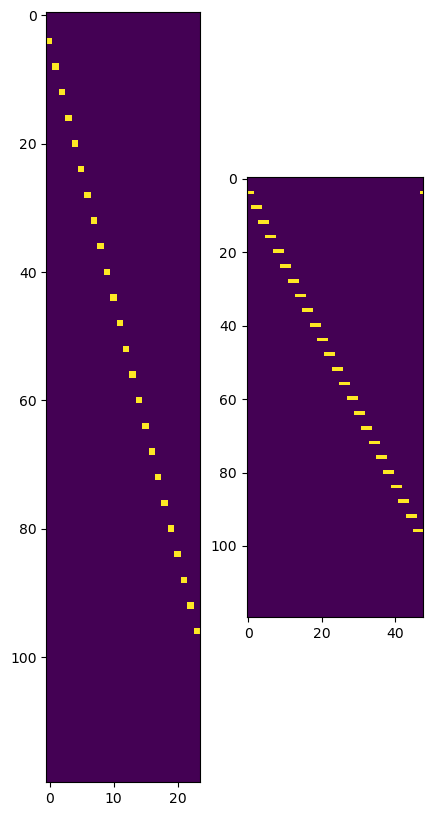

In [8]:
plt.figure(figsize=(5, 10))
plt.subplot(1, 2, 1)
plt.imshow(dm)
plt.subplot(1, 2, 2)
plt.imshow(new_dm)
plt.show()

## How does the model look like?

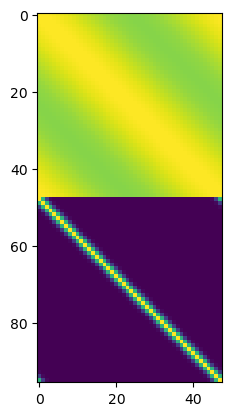

In [9]:
plt.imshow(models)
plt.show()

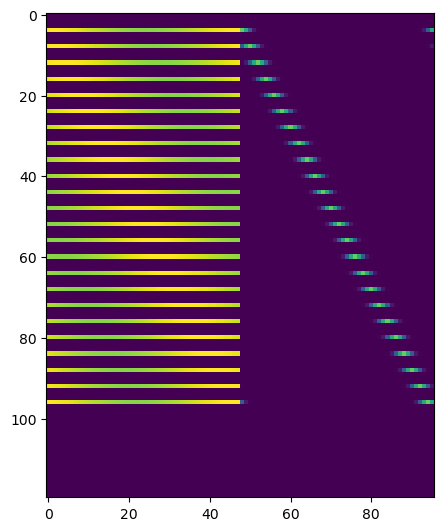

In [10]:
plt.figure(figsize=(5,20))
plt.imshow(grid_model_timecourses.T)
plt.show()

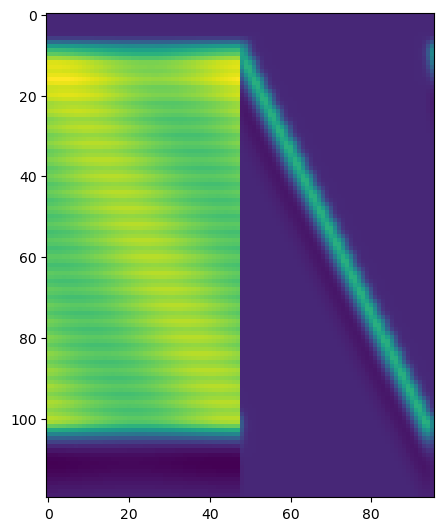

In [11]:
plt.figure(figsize=(5,20))
plt.imshow(grid_model_timecourses_conv.T)
plt.show()

## Make some fake data

In [12]:
# assume there are 8 voxels, each with a timecourse of 50 TRs, and corresponding to a the dm above
sv_tcs = np.random.randn(timepoints, angle_nr)/100
kappa_log10_range = [np.log10(kappa_range[0]), np.log10(kappa_range[1])]
mus_dm = np.linspace(0, 2 * np.pi, dm.shape[1], endpoint=False)
mus = np.linspace(0, 2 * np.pi, oversamplingratio * angle_nr, endpoint=False)
kappas = np.logspace(
    kappa_log10_range[0], [kappa_log10_range[1]], kappas_nr, endpoint=True
)
# kappas_dm = [kappas[i] for i in [0, 1, 2, 0, 1, 2, 0, 1]]
kappas_dm = [kappas[i] for i in angle_nr*[1]]
# each voxel in dm_kappa is affected by other voxels according to the kappa value of the model
dm_kappa = np.zeros_like(dm)

for i in range(dm.shape[0]):
    if any(dm[i, :]):
        on_angle = np.where(dm[i, :])[0][0]
        for j in range(dm.shape[1]):
            dm_kappa[i, j] = vm(mus, mus_dm[on_angle], kappas_dm[j])[j*oversamplingratio]
# each voxel's timecourse is convolved with the hrf
hrfdata = sp.signal.fftconvolve(
    dm_kappa.T, hrf, mode="full", axes=(-1)
)[..., : dm.T.shape[-1]]
sv_tcs += hrfdata.T

In [13]:
on_angle = np.where(dm[12, :])[0][0]
print(f"on_angle: {on_angle}")
print(f"mus_dm: {mus_dm}")
print(f"mus_dm[on_angle]: {mus_dm[on_angle]}")


on_angle: 2
mus_dm: [0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327
 3.14159265 3.40339204 3.66519143 3.92699082 4.1887902  4.45058959
 4.71238898 4.97418837 5.23598776 5.49778714 5.75958653 6.02138592]
mus_dm[on_angle]: 0.5235987755982988


In [14]:
mus

array([0.        , 0.13089969, 0.26179939, 0.39269908, 0.52359878,
       0.65449847, 0.78539816, 0.91629786, 1.04719755, 1.17809725,
       1.30899694, 1.43989663, 1.57079633, 1.70169602, 1.83259571,
       1.96349541, 2.0943951 , 2.2252948 , 2.35619449, 2.48709418,
       2.61799388, 2.74889357, 2.87979327, 3.01069296, 3.14159265,
       3.27249235, 3.40339204, 3.53429174, 3.66519143, 3.79609112,
       3.92699082, 4.05789051, 4.1887902 , 4.3196899 , 4.45058959,
       4.58148929, 4.71238898, 4.84328867, 4.97418837, 5.10508806,
       5.23598776, 5.36688745, 5.49778714, 5.62868684, 5.75958653,
       5.89048623, 6.02138592, 6.15228561])

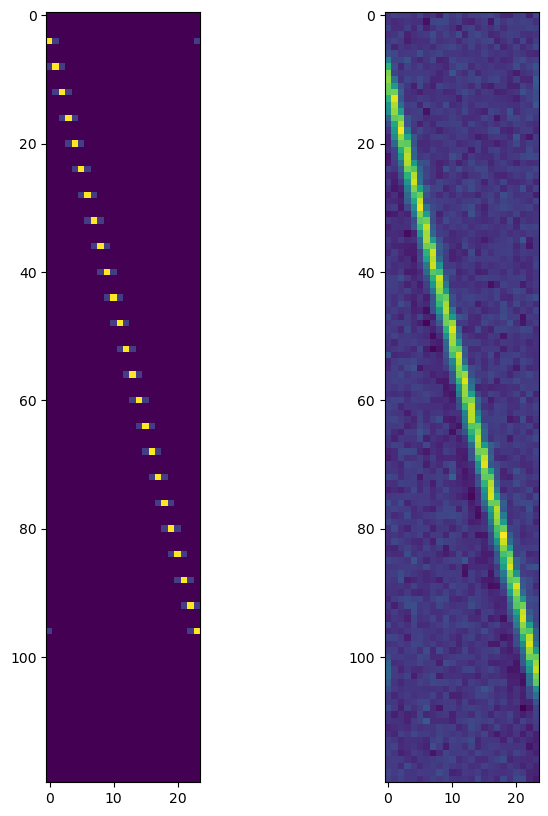

In [15]:
plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.imshow(dm_kappa)
plt.subplot(1, 2, 2)
plt.imshow(sv_tcs)
plt.show()

## Check if the model is correct
Pick one random model (based an angle value and a kappa value) to check how well the model fits the data

models number is 96, oversampled angles number is 48
angle number is 24, oversampleratio is 2.0
Corresponding angle: 30.00, kappa for this model: 0.10
dm shape: (120, 24), new_dm shape: (120, 48)


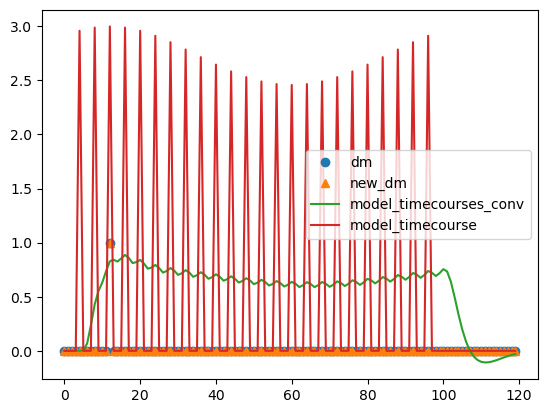

In [16]:
chosen_model = 4
print(f"models number is {models.shape[0]}, oversampled angles number is {models.shape[1]}")
print(f"angle number is {angle_nr}, oversampleratio is {models.shape[0]/models.shape[1]}")
print(f"Corresponding angle: {np.degrees(mugrid[chosen_model]):.2f}, kappa for this model: {kappagrid[chosen_model]:.2f}")
print(f"dm shape: {dm.shape}, new_dm shape: {new_dm.shape}")
plt.plot(dm[:,int(round(np.degrees(mugrid[chosen_model]/(360/angle_nr))))], 'o', label='dm')
plt.plot(new_dm[:,int(round(np.degrees(mugrid[chosen_model]/(360/(angle_nr*oversamplingratio)))))], '^', label='new_dm')
plt.plot(grid_model_timecourses_conv[chosen_model, :], label='model_timecourses_conv')
plt.plot(model_timecourse(models[chosen_model, :], new_dm), label='model_timecourse')
plt.legend()
plt.show()

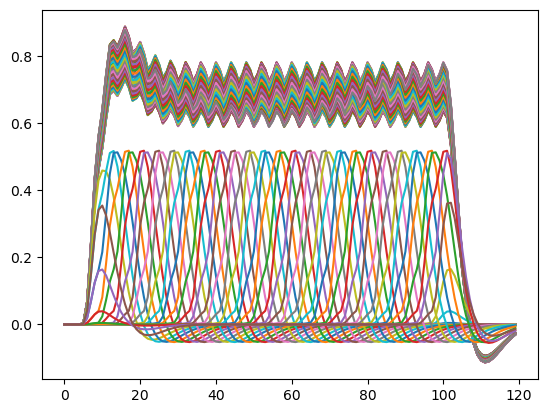

In [34]:
for mtcs in grid_model_timecourses_conv:
    plt.plot(mtcs)
plt.show()

In [17]:
# if we have a stimulus at 0 degrees, we should see a peak at 0 degrees
angles = np.linspace(0, 360, angle_nr, endpoint=False)
angle_to_stim_screen(
    0, angle_nr, stim_radius, oversamplingratio=oversamplingratio
)

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [18]:
rsq, best_angle, best_kappa = grid_search_for_voxel(
    sv_tcs.T, grid_model_timecourses_conv, mugrid, kappagrid
)

In [21]:
print(f"best angle: {np.degrees(best_angle)}, \nbest kappa: {best_kappa}, \nrsq: {rsq}")

best angle: [  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165. 180. 195.
 210. 225. 240. 255. 270. 285. 300. 315. 330. 345.], 
best kappa: [50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50.], 
rsq: [0.95585804 0.96400462 0.96376459 0.95754017 0.96897633 0.95687497
 0.95199794 0.96394978 0.95368893 0.95694437 0.95337464 0.96236264
 0.95816917 0.9659147  0.95838342 0.96427183 0.95578117 0.95717277
 0.96223583 0.96720229 0.9554736  0.95168822 0.96184494 0.95409841]


## Test the model on a single voxel

In [35]:
rsqs = np.array(
    [rsq_for_model(sv_tcs.T[0], mtcs) for mtcs in grid_model_timecourses_conv]
)
print(f"rsqs shape: {rsqs.shape}")
print(f"mugrid shape: {mugrid.shape}")
print(f"kappagrid shape: {kappagrid.shape}")
best_fitting_model = np.argmax(rsqs, axis=0)
print(f"best_fitting_model: {best_fitting_model}")
best_angle, best_kappa = (
    mugrid[best_fitting_model],
    kappagrid[best_fitting_model],
)
rsq = rsq_for_model(
    sv_tcs.T, grid_model_timecourses_conv[best_fitting_model], return_yhat=False
)
print(f"best angle: {np.degrees(best_angle)}, \nbest kappa: {best_kappa}, \nrsq: {rsq}")

rsqs shape: (96,)
mugrid shape: (96,)
kappagrid shape: (96,)
best_fitting_model: 48
best angle: 0.0, 
best kappa: 49.99999999999999, 
rsq: [0.92441718 0.43828066 0.01674443 0.01563719 0.03933924 0.01712998
 0.01208141 0.01312561 0.01321976 0.01147368 0.00645289 0.00596956
 0.00334039 0.00983066 0.00820966 0.0078769  0.00767019 0.0109047
 0.01442587 0.02248771 0.02315108 0.00380115 0.01034011 0.12218684]
